In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.autograd import Function

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import json
import numpy as np
from PIL import Image

from models import SegmentationModel
from dataloader import get_dataloader, walk_through_dir
from pathlib import Path
import random

In [2]:
# check if gpu available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
data_path = "/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/"
walk_through_dir(Path(data_path))

There are 2 directories and 2 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data'.
There are 7 directories and 0 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield'.
There are 0 directories and 2475 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well5_225locations'.
There are 0 directories and 2475 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well4_225locations'.
There are 0 directories and 1485 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well6_135locations'.
There are 0 directories and 2156 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well3_200locations'.
There are 0 directories and 1485 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well7_

In [4]:
image_dirs = [data_path + 'brightfield/Alexa488_Fibroblasts_well1_50locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well2_200locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well3_200locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well4_225locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well5_225locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well6_135locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well7_135locations']
mask_dir = data_path + 'masks'

In [5]:
def set_seed(seed=111):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
    random.seed(seed)
    np.random.seed(seed)

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
mask_transform = data_transform

train_dataloader, test_dataloader = get_dataloader(image_dirs, mask_dir, data_transform, mask_transform, display_sample=False)

Number of images in the trainset: 1112
Number of images in the testset: 50


In [7]:
# init architecture
model = SegmentationModel()

# loading the pretrained model
state_dict = torch.load('segmentation_model.pth', map_location=torch.device('cpu'))

# load weights into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

/tmp/ipykernel_1329306/3664573750.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('segmentation_model.pth', map_location=torch.device('cpu'))


SegmentationModel(
  (enc1): Sequential(
    (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [8]:
# Sample evaluation
batch = next(iter(test_dataloader))  # Get one batch
images, masks = batch

random_idx = random.randint(0, images.size(0) - 1)  # Random index within batch size
random_images = images.to(device)
random_mask = masks[random_idx].to(device) # Select only one random sample to plot

model.eval()

SegmentationModel(
  (enc1): Sequential(
    (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [9]:
# Extract the random image
random_image = images[random_idx].unsqueeze(0).to(device)  # Add batch dimension
random_mask = masks[random_idx].to(device)  # Ground truth mask for the random sample

# Set up input_tensor with requires_grad=True
input_tensor = random_image.clone().detach()
input_tensor.requires_grad = True

# Perform forward pass
output = model(input_tensor)

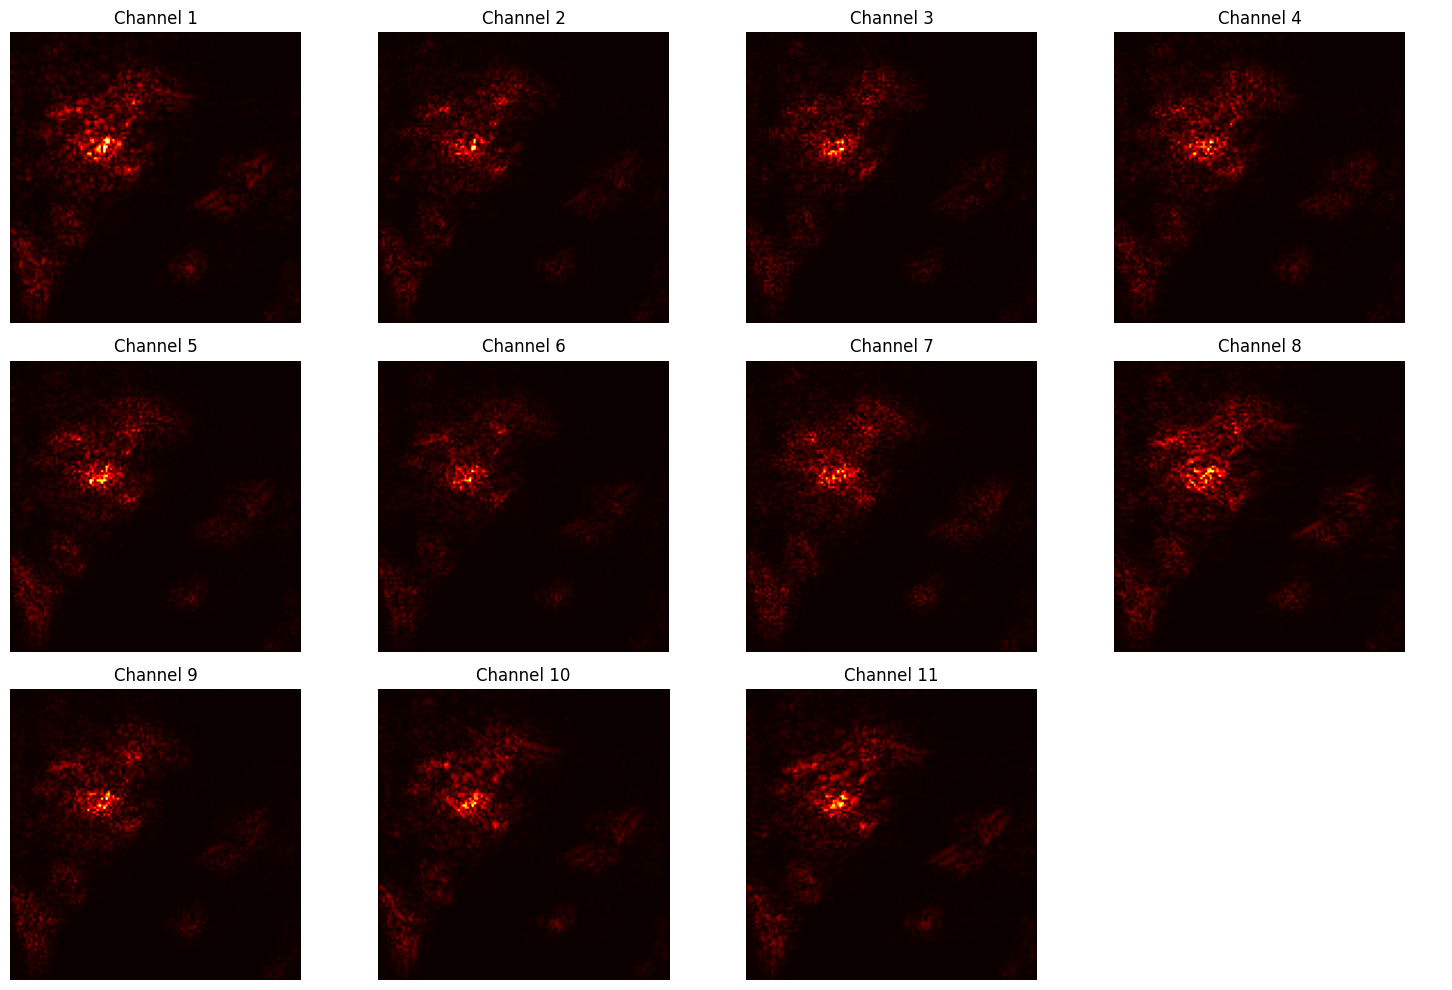

In [10]:
# forward pass
# output = model(input_tensor)
binary_output = (output > 0.5).float() # Make binary segmentation

# define a target
# target = output[0, 0].mean()

masked_output = output[0, 0] * (output[0, 0] > 0.5).float()  # Mask without breaking gradients
target = masked_output.mean()

# Backward pass to compute gradients
target.backward()

# Get saliency maps (absolute gradients of the input)
saliency = input_tensor.grad.abs().detach().squeeze(0)

# Plot saliency maps for each input channel
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns (extra space for 11th channel)

for i in range(11):
    row, col = divmod(i, 4)  # Compute row and column indices
    ax = axes[row, col]
    ax.imshow(saliency[i].cpu().numpy(), cmap='hot')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')

# Turn off any unused subplots (12th plot in a 3x4 layout)
if 11 < 12:
    axes[2, 3].axis('off')

plt.tight_layout()
plt.show()

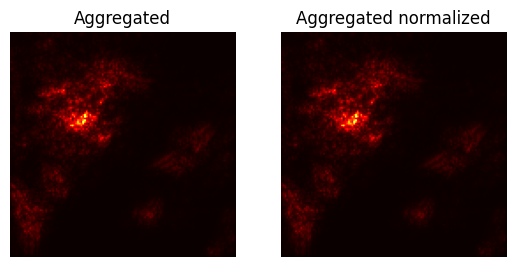

In [11]:
aggregated_saliency = saliency.sum(dim=0)  # Sum across input channels

plt.subplot(1, 2, 1)
plt.imshow(aggregated_saliency.cpu().numpy(), cmap='hot')
plt.axis('off')
plt.title("Aggregated")

# normalized aggregated saliency map
saliency_norm = saliency / saliency.max()
agg_saliency_norm = saliency_norm.sum(dim= 0)

plt.subplot(1, 2, 2)
plt.imshow(agg_saliency_norm.cpu().numpy(), cmap='hot')
plt.axis('off')
plt.title("Aggregated normalized")

plt.show()

(128, 128)


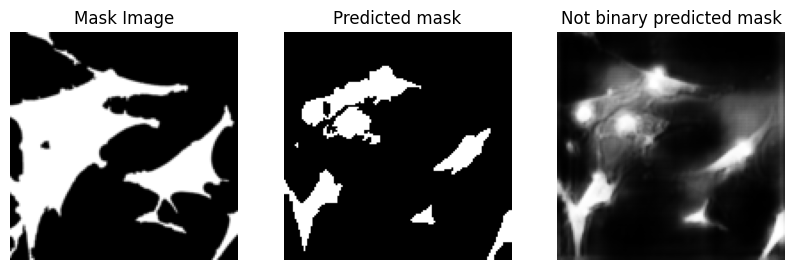

In [12]:
# print the output mask
output_mask = output.squeeze().cpu().detach().numpy()
print(output_mask.shape)

plt.figure(figsize=(10, 5))

# print the mask image
random_mask = masks[random_idx].to(device)

# Display the original output mask
plt.subplot(1, 3, 1)
plt.imshow(random_mask.cpu().squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title("Mask Image")

# Display the predicted output mask
plt.subplot(1, 3, 2)
plt.imshow(binary_output.cpu().squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title("Predicted mask")


# not binary output
plt.subplot(1, 3, 3)
plt.imshow(output.cpu().squeeze().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title("Not binary predicted mask")
plt.show()

In [ ]:
# Function to compute Grad-CAM
def compute_gradcam(model, input_tensor, target_layer_name):
    gradients = []  # To store gradients
    activations = []  # To store activations

    # Hook to capture gradients and activations
    def forward_hook(module, input, output):
        activations.append(output)  # Capture the activations
        
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])  # Capture the gradients

    # Register hooks to the target layer
    target_layer = dict(model.named_modules())[target_layer_name]
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    try:
        # Forward pass
        output = model(input_tensor)

        # Target output
        masked_output = output[0, 0] * (output[0, 0] > 0.5).float()  # Mask without breaking gradients
        target = masked_output.mean()

        # Compute gradients for the target output
        model.zero_grad()  # Clear previous gradients
        target.backward()

        # Extract gradients and activations
        gradients = gradients[0].detach()  # Shape: [B, C, H, W]
        activations = activations[0].detach()  # Shape: [B, C, H, W]

        # Compute Grad-CAM weights: global average pooling of gradients
        weights = gradients.mean(dim=(2, 3), keepdim=True)  # Shape: [B, C, 1, 1]

        # Weighted sum of activations
        gradcam = (weights * activations).sum(dim=1).squeeze()  # Shape: [H, W]

        # Apply ReLU to keep only positive contributions
        gradcam = F.relu(gradcam)

        # Normalize Grad-CAM to range [0, 1]
        gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())

        return gradcam.cpu().numpy()
    finally:
        # Ensure hooks are removed after computation
        forward_handle.remove()
        backward_handle.remove()


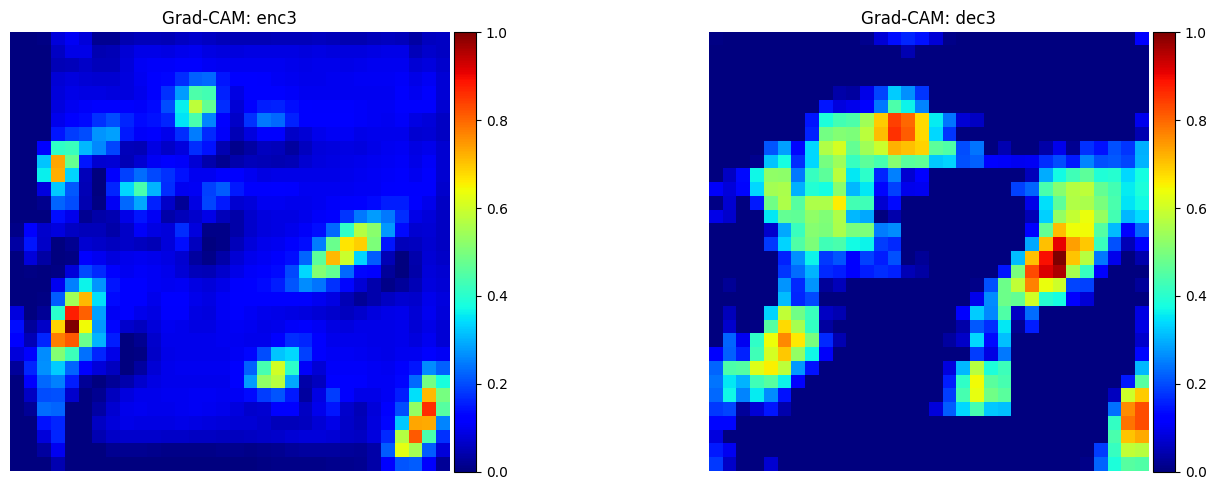

In [ ]:
# Set model to evaluation mode
model.eval()

# Specify target layer 
target_layer_name_e3 = "enc3"  # layer at depth 3 in encoder
target_layer_name_d3 = "dec3"

# Compute Grad-CAM
gradcam_enc3 = compute_gradcam(model, input_tensor, target_layer_name_e3)
gradcam_dec3 = compute_gradcam(model, input_tensor, target_layer_name_d3)

# Plot Grad-CAM results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create 3 subplots

gradcam_results = [gradcam_enc3, gradcam_dec3]  # Grad-CAM heatmaps
titles = ["Grad-CAM: enc3", "Grad-CAM: dec3"]

for ax, gradcam, title in zip(axes, gradcam_results, titles):
    # Plot Grad-CAM heatmap
    im = ax.imshow(gradcam, cmap="jet")
    ax.axis("off")
    ax.set_title(title)

    # Create a colorbar proportional to the plot size
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()